In [1]:
!pip install pymysql

     |████████████████████████████████| 43 kB 569 kB/s eta 0:00:01


In [2]:
import pymysql
import pandas as pd
from shapely import wkt
import geopandas
import matplotlib.pyplot as plt
from pysal.lib import weights
import contextily
import seaborn
from pysal.explore import esda
from splot.esda import plot_moran

## connect to bo

In [3]:
def conn(host,port,db):
    db_settings = {
        "host": host,
        "port": port,
        "user": "root",
        "password": "",
        "db": db,
        "charset": "utf8",
        "connect_timeout":31536000
    }

    try:
        conn = pymysql.connect(**db_settings)
        print("success connect to bo!!")
    except Exception as ex:
        conn = None
        print(ex)
    return conn

def query(conn,command):
    with conn.cursor() as cursor:
        cursor.execute(command)
        result = cursor.fetchall()
        return result  

In [23]:
c = conn("house_bo",3306,"bigobject")

success connect to bo!!


## read spatial data

In [5]:
code02 = pd.DataFrame(query(c,"select * from house.area_code2 where city in ('臺北市','新北市')"))
code02 = code02.set_axis(['code2', 'townid', 'town', 'city_id', 'city','u_id',"area",'y','x','geometry','polygon'], axis=1, inplace=False)

In [6]:
code02.head(3)

,code2,townid,town,city_id,city,u_id,area,y,x,geometry,polygon
0,A6501-05,65000010,板橋區,65000,新北市,5,56593.5443,25.032466,121.476122,MULTIPOLYGON (((121.4760850367192 25.033266967...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
1,A6501-06,65000010,板橋區,65000,新北市,6,41802.6326,25.032153,121.470141,MULTIPOLYGON (((121.4710964634274 25.032148007...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
2,A6501-07,65000010,板橋區,65000,新北市,7,49451.5894,25.031605,121.477198,MULTIPOLYGON (((121.4793620134134 25.031974856...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...


In [7]:
code02['geometry'] = geopandas.GeoSeries.from_wkt(code02['geometry'])

In [8]:
gdf = geopandas.GeoDataFrame(code02, geometry='geometry')

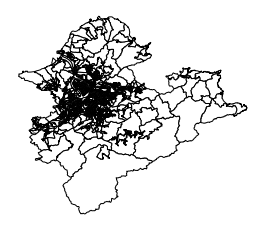

In [9]:
# Plot grid geotable
ax = gdf.plot(facecolor='w', edgecolor='k')
    
# Remove axes
ax.set_axis_off()
plt.show()

-----
# Contiguity Weights空間相鄰權重矩陣

## 1.Rook:多邊形共用同一個邊

In [10]:
wr = weights.contiguity.Rook.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 11 islands with ids: 327, 830, 1237, 1241, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


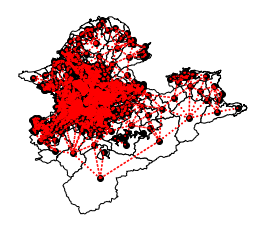

In [11]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [12]:
# 計算非0的數量
wr.nonzero

12088

In [13]:
# 次數分配
pd.DataFrame(wr.histogram).head(15)

,0,1
0,0,11
1,1,6
2,2,45
3,3,238
4,4,519
5,5,604
6,6,390
7,7,215
8,8,87
9,9,44


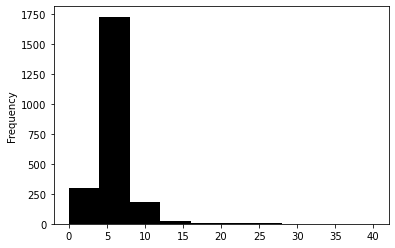

In [14]:
pd.Series(wr.cardinalities).plot.hist(color='k');

In [15]:
print("連接數："+str(wr.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wr.pct_nonzero,3)))

連接數：12088.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.239


## 2.Queen:多邊形共用一個或多個點

In [16]:
wq = weights.contiguity.Queen.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 10 islands with ids: 327, 830, 1237, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


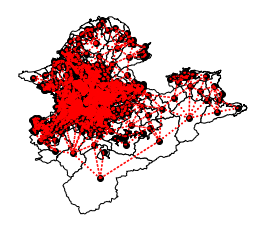

In [17]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [18]:
wq.nonzero

13366

In [19]:
pd.DataFrame(wq.histogram).head(15)

,0,1
0,0,10
1,1,3
2,2,36
3,3,145
4,4,398
5,5,526
6,6,467
7,7,279
8,8,171
9,9,83


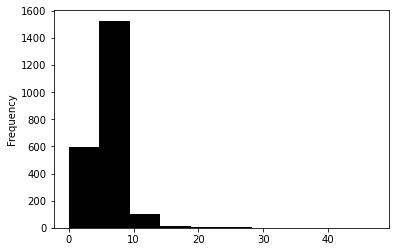

In [20]:
pd.Series(wq.cardinalities).plot.hist(color='k');

In [21]:
print("連接數："+str(wq.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wq.pct_nonzero,3)))

連接數：13366.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.264


-----------------
# Spatial Autocorrelation空間自相關

In [24]:
sql = """select code2,unit_price,b.geometry as geometry from 
  (select  code2,avg(unit_price) as unit_price from 108S3.house_buy  
  where city in ('臺北市','新北市') and not transaction_sign in ('車位','土地')  and tgosresaddress <> '找不到指定的門牌地址。'
  group by code2) a 
inner join house.area_code2 b on a.code2 = b.code2"""
data = pd.DataFrame(query(c,sql))

In [25]:
data = data.set_axis(['code2', 'unit_price', 'geometry'], axis=1, inplace=False)
data['geometry'] = geopandas.GeoSeries.from_wkt(data['geometry'])

In [26]:
data.head()

,code2,unit_price,geometry
0,A6305-47,121073.333333,"MULTIPOLYGON (((121.52361 25.02260, 121.52394 ..."
1,A6308-57,212080.714286,"MULTIPOLYGON (((121.56615 24.98853, 121.56529 ..."
2,A6308-29,153327.500000,"MULTIPOLYGON (((121.55264 24.99956, 121.55249 ..."
3,A6307-36,201192.000000,"MULTIPOLYGON (((121.49338 25.02860, 121.49338 ..."
4,A6306-24,148838.142857,"MULTIPOLYGON (((121.51369 25.06299, 121.51374 ..."


In [27]:
db = geopandas.GeoDataFrame(data)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   code2       2112 non-null   object  
 1   unit_price  2112 non-null   float64 
 2   geometry    2112 non-null   geometry
dtypes: float64(1), geometry(1), object(1)
memory usage: 49.6+ KB


/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


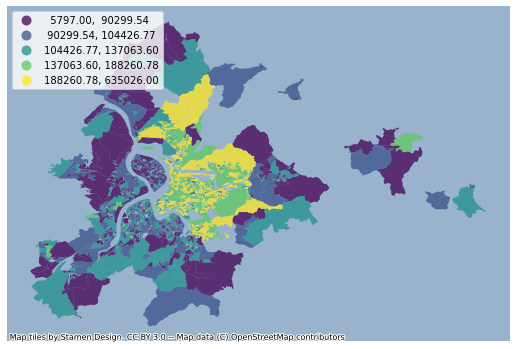

In [28]:
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='unit_price', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax
       )
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [29]:
w = weights.contiguity.Rook.from_dataframe(db)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 5 islands with ids: 116, 369, 1903, 1908, 2028.
  warnings.warn(message)


In [30]:
db['unit_price_lag'] = weights.spatial_lag.lag_spatial(w, db['unit_price'])

In [31]:
db.head()

,code2,unit_price,geometry,unit_price_lag
0,A6305-47,121073.333333,"MULTIPOLYGON (((121.52361 25.02260, 121.52394 ...",1.345590e+06
1,A6308-57,212080.714286,"MULTIPOLYGON (((121.56615 24.98853, 121.56529 ...",6.180784e+05
2,A6308-29,153327.500000,"MULTIPOLYGON (((121.55264 24.99956, 121.55249 ...",9.885799e+05
3,A6307-36,201192.000000,"MULTIPOLYGON (((121.49338 25.02860, 121.49338 ...",6.841688e+05
4,A6306-24,148838.142857,"MULTIPOLYGON (((121.51369 25.06299, 121.51374 ...",9.704533e+05


/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 28 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


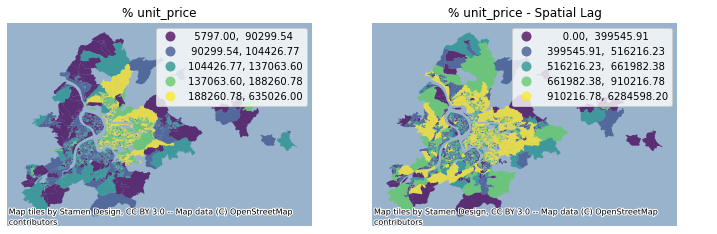

In [32]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(column='unit_price', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% unit_price")
contextily.add_basemap(ax1, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

db.plot(column='unit_price_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% unit_price - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

plt.show()

In [33]:
# pct_leave和pct_leave_lag標準化
db['unit_price_std'] = (db['unit_price'] - db['unit_price'].mean()) / db['unit_price'].std()
db['unit_price_lag_std'] = ( db['unit_price_lag'] - db['unit_price_lag'].mean()) / db['unit_price_lag'].std()

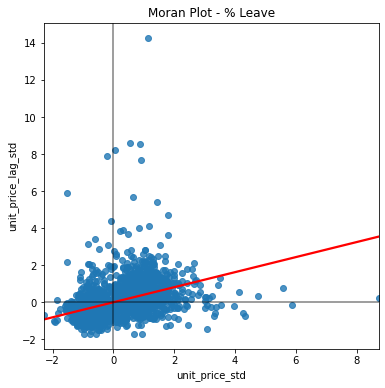

In [34]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='unit_price_std', y='unit_price_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Leave')
plt.show()

In [35]:
# 計算moran's i
moran = esda.moran.Moran(db['unit_price'], w)
moran.I

('WARNING: ', 116, ' is an island (no neighbors)')
('WARNING: ', 369, ' is an island (no neighbors)')
('WARNING: ', 1903, ' is an island (no neighbors)')
('WARNING: ', 1908, ' is an island (no neighbors)')
('WARNING: ', 2028, ' is an island (no neighbors)')


0.6227329656570271

In [36]:
# empirical p-value:夠小的p-vale允許拒絕地圖是隨機的假設
moran.p_sim

0.001

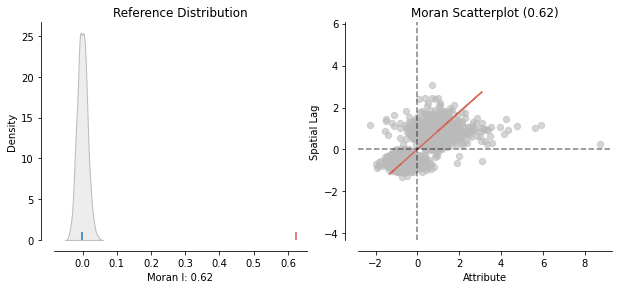

In [37]:
plot_moran(moran);

## 2.Local Autocorrelation

In [38]:
db['w_unit_price'] = weights.spatial_lag.lag_spatial(w, db['unit_price'])

In [39]:
db['w_unit_price_std'] = ( db['w_unit_price'] - db['unit_price'].mean() ) / db['unit_price'].std()

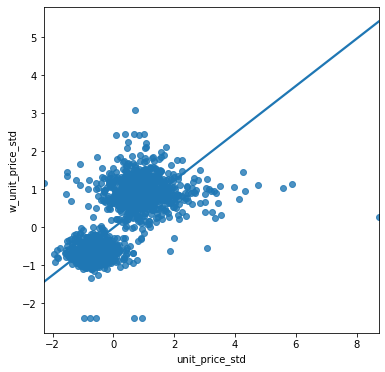

In [40]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Display
plt.show()

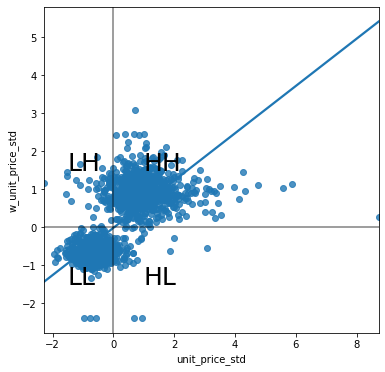

In [41]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [46]:
# 計算LISA(因為有island所以沒辦法算)
lisa = esda.moran.Moran_Local(db['unit_price'], w)

ValueError: cannot assign slice from input of different size

-----------------
# 空間迴歸模型

In [ ]:
from pysal.model import spreg